In [1]:
#Addresses for reading address information, building footprint coordinates, and parcel outline coordinates
root_path           = 'C:/Users/ntste/Documents/Insight/Tree Data/'
root_image_path     = root_path + 'SAS Output/'
generate_image_path = 'C:/Users/ntste/Documents/Insight/Tree Data/SAS Output/Code/generateImages.ipynb'
tree_detector_path  = 'C:/Users/ntste/Documents/Insight/Code/train_yolo_to_detect_custom_object/yolo_custom_detection/'
address_info_path   = root_path + 'LA_County_Parcels_small.csv'
footprint_info_path = root_path + 'Building_Footprints-shp/footprint_nodes.csv'
parcel_info_path    = root_path + 'parcel_locations.csv'

In [2]:
import pandas as pd
address_info   = pd.read_csv(address_info_path)
footprint_info = pd.read_csv(footprint_info_path)
parcel_info    = pd.read_csv(parcel_info_path,dtype={'PARCEL_WKT': str, 'AIN': str})

In [3]:
#Format parcel info
parcel_info = parcel_info.dropna()
parcel_info = parcel_info[(parcel_info.AIN != 'nan')] #remove nan strings that aren't actual NaNs
parcel_info = parcel_info[(parcel_info.AIN != ' ')]
parcel_info = parcel_info[parcel_info.AIN.str.isnumeric()]
parcel_info['AIN'] = parcel_info['AIN'].astype('int64')

In [4]:
#perform inner join of all tables by AIN
#master_table = pd.concat([address_info,footprint_info], axis = 1, join = 'inner')
master_table = address_info.merge(footprint_info, how = 'inner', on = ['AIN'])
master_table = master_table.merge(parcel_info, how = 'inner', on = ['AIN'])
master_table = master_table.loc[master_table['SitusFullAddress'].str.contains('91042', na=False)]
print(master_table.columns)
master_table.head()

Index(['OBJECTID_x', 'AIN', 'APN', 'SitusCity', 'SitusFullAddress',
       'TaxRateCity', 'CENTER_LAT', 'CENTER_LON', 'CENTER_X', 'CENTER_Y',
       'LAT_LON', 'ShapeSTArea', 'ShapeSTLength', 'Shape', 'WKT', 'OBJECTID_y',
       'CODE', 'BLD_ID', 'HEIGHT', 'ELEV', 'AREA', 'LARIAC_SOU', 'LARIAC_DAT',
       'STATUS', 'CODE_NUM', 'coords', 'PARCEL_WKT'],
      dtype='object')


,OBJECTID_x,AIN,APN,SitusCity,SitusFullAddress,TaxRateCity,CENTER_LAT,CENTER_LON,CENTER_X,CENTER_Y,...,BLD_ID,HEIGHT,ELEV,AREA,LARIAC_SOU,LARIAC_DAT,STATUS,CODE_NUM,coords,PARCEL_WKT
1247,1898,2557003032,2557-003-032,LOS ANGELES CA,7760 KYLE ST LOS ANGELES CA 91042,LOS ANGELES,34.264567,-118.302256,6470342.067,1918800.279,...,470333918801,25.32,1548.10,1586,LARIAC2,2008,Unchanged,1,NaN,MULTIPOLYGON (((-118.302145795873 34.264664840...
1248,1900,2557004005,2557-004-005,LOS ANGELES CA,10714 TINKER AVE LOS ANGELES CA 91042,LOS ANGELES,34.263736,-118.301404,6470598.580,1918497.274,...,2014112897480000,11.32,1554.13,1057,LARIAC4,2014,Modified,1,NaN,MULTIPOLYGON (((-118.301214755279 34.263787759...
1249,1901,2557004016,2557-004-016,LOS ANGELES CA,10714 IRMA AVE LOS ANGELES CA 91042,LOS ANGELES,34.263721,-118.300626,6470833.771,1918491.147,...,470863918466,7.86,1565.20,112,LARIAC2,2008,Unchanged,1,NaN,MULTIPOLYGON (((-118.300491417603 34.263812477...
1250,1901,2557004016,2557-004-016,LOS ANGELES CA,10714 IRMA AVE LOS ANGELES CA 91042,LOS ANGELES,34.263721,-118.300626,6470833.771,1918491.147,...,2014112898170000,8.37,1563.97,1610,LARIAC4,2014,Modified,1,NaN,MULTIPOLYGON (((-118.300491417603 34.263812477...
1251,1902,2557004020,2557-004-020,LOS ANGELES CA,7667 HILLROSE ST LOS ANGELES CA 91042,LOS ANGELES,34.263562,-118.300216,6470957.310,1918432.894,...,470958918427,8.03,1571.65,1709,LARIAC2,2008,Unchanged,1,NaN,MULTIPOLYGON (((-118.300130999876 34.263777045...


In [5]:
def image_by_address(master_table, address, imsize = 1024, classified = False):
    """
    Returns imsize x imsize RGB image centering around lot center location based on address
    Calls generateImages class
    master_table: joined table containing addresses, parcels, and building outlines
    address: string with full address
    imsize: side length of image in pixels
    """
    import import_ipynb
    from generateimages import generateImages as gi
    
    row        = master_table.loc[master_table['SitusFullAddress'] == address]
    center_lat = float(list(row['LAT_LON'])[0].split(',')[0])
    center_lon = float(list(row['LAT_LON'])[0].split(',')[1])
    
    imfo       = gi(root_image_path, center_lat, center_lon)
    image      = imfo.generate_image(classified = classified)
    
    return image, imfo, center_lat, center_lon, row

In [6]:
def map_by_address(image, thresh, class_label = 5, imsize = 1024):
    """
    Returns imsize x imsize binary image centering around lot center location based on address
    Calls generateImages class; shows estimated tree locations
    image: input image with kmeans classifications
    class_label: class label in kmeans classified image (defaults to trees)
    imsize: side length of image in pixels
    """
    label_image,labeled, ncomponents = remove_small_clusters(image,thresh,class_label,class_pick = True)
    
    return label_image

In [7]:
 def remove_small_clusters(im,thresh,tree_class=5,class_pick = False):
    """
    Isolates tree-heavy class for kmeans classified image and 
    performs connected component analysis to remove components where
    N_pixels < thresh
    returns binary image of large tree clusters
    """
    import numpy as np
    from scipy import ndimage
    import scipy.misc
    from scipy.ndimage.measurements import label
    import skimage.measure
    
    if class_pick:
        isolated_class_image = im == tree_class
    else:
        isolated_class_image = im
        
    isolated_class_image.astype(int)
    structure            = np.ones((3,3), dtype = np.int)
    labeled,ncomponents  = label(isolated_class_image,structure)
    unique, counts       = np.unique(labeled, return_counts=True)
    chunks               = dict(zip(unique, counts))
    chunks               = {key:val for key, val in chunks.items() if ((val > thresh) and (val != max(chunks.values())))}
    output_map           = np.zeros_like(isolated_class_image)
    keys                 = [key for key in chunks]
    for i in keys:
        output_map[labeled == i] = 1
        
    return output_map, labeled, ncomponents    

In [8]:
def structures_by_address(master_table, address):
    """
    Returns list of containing the GPS locations of vertices outlining the main structure at a given address
    """
    row = master_table.loc[master_table['SitusFullAddress'] == address]
    wkt = list(row['WKT'])
    return wkt[0].split('MULTIPOLYGON (((')[1].split(')')[0].split(',')

In [9]:
def parcel_boundaries_by_address(master_table, address):
    """
    Returns list of containing the GPS locations of vertices outlining the property boundaries at a given address
    """
    row = master_table.loc[master_table['SitusFullAddress'] == address]
    wkt = list(row['PARCEL_WKT'])
    return wkt[0].split('MULTIPOLYGON (((')[1].split(')')[0].split(',')

In [10]:
def convert_vertices_to_pixels(vertices, image_info, imsize = 1024):
    """
    Returns a list of tuples containing (x,y) location in pixels defining a polygon
    vertices: list of strings of lat, lon returned by structures_by_address
    """
    from osgeo import gdal
    
    center_coordinates = image_info.center_coords
    ul_subset_x        = center_coordinates[0] - imsize/2. #x pixel location of upper left corner in subset image
    ul_subset_y        = center_coordinates[1] - imsize/2. #y pixel location of upper left corner in subset image

    vertex_coordinates = []
    driver = gdal.GetDriverByName('GTiff')
    filename = image_info.parent_image_path #path to raster
    dataset = gdal.Open(filename)
    band = dataset.GetRasterBand(1)
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    transform = dataset.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]
    data = band.ReadAsArray(0, 0, cols, rows)
    points_list = [(float(vertex.split()[0]),float(vertex.split()[1])) for vertex in vertices] #list of X,Y coordinates
    for point in points_list:
        col = int((point[0] - xOrigin) / pixelWidth)
        row = int((yOrigin - point[1] ) / pixelHeight)
        vertex_coordinates.append((col-ul_subset_x, row-ul_subset_y))
    
    return vertex_coordinates    

In [11]:
def structure_intersection_map(tree_map, structure_vertices, imsize = 1024):
    """
    Return boolean image showing regions where structures and trees overlap
    """
    import PIL.ImageDraw as ImageDraw
    import PIL.Image as Image
    import numpy as np
    
    poly_image = Image.new("RGB", (imsize,imsize))
    draw = ImageDraw.Draw(poly_image)
    draw.polygon(tuple(structure_vertices), fill = 2)
    overlap = np.array(poly_image)[:,:,0]*tree_map == 2
    
    return overlap, True in overlap

In [12]:
def bresenham_line(x0, y0, x1, y1):
    """
    Returns a list of (x,y) tuples of pixel locations connecting the input points
    """
    steep = abs(y1 - y0) > abs(x1 - x0)
    if steep:
        x0, y0 = y0, x0  
        x1, y1 = y1, x1

    switched = False
    if x0 > x1:
        switched = True
        x0, x1 = x1, x0
        y0, y1 = y1, y0

    if y0 < y1: 
        ystep = 1
    else:
        ystep = -1

    deltax = x1 - x0
    deltay = abs(y1 - y0)
    error = -deltax / 2
    y = y0

    line = []    
    for x in range(x0, x1 + 1):
        if steep:
            line.append((y,x))
        else:
            line.append((x,y))

        error = error + deltay
        if error > 0:
            y = y + ystep
            error = error - deltax
    if switched:
        line.reverse()
    return line

In [13]:
def get_parcel_pixels(parcel_coordinates):
    import itertools
    """
    Takes in parcel coordinates returned by convert_vertices_to_pixels
    Returns list of all (x,y) points connecting those vertices in a straight line
    """
    parcel_pixels = [bresenham_line(int(parcel_coordinates[i][0]), int(parcel_coordinates[i][1]), int(parcel_coordinates[i+1][0]), int(parcel_coordinates[i+1][1])) for i in range(len(parcel_coordinates)-1)]
    return list(itertools.chain.from_iterable(parcel_pixels))

In [14]:
def get_parcel_image(parcel_pixels, imsize = 1024):
    """
    Input: parcel pixels from get_parcel_pixels, image size in pixels
    Returns imsize^2 nummpy array with parcel pixels as 2 and others as 0
    """
    import numpy as np
    parcel_image = np.zeros((imsize,imsize,3))
    for i in range(len(parcel_pixels)):
        parcel_image[parcel_pixels[i][1],parcel_pixels[i][0],:] = 2
    return parcel_image

In [15]:
def parcel_intersection_map(tree_map, parcel_image, warn_padding, imfo):
    """
    Return boolean image showing regions where property lines and trees overlap
    tree_map: input map of tree locations
    parcel_image: input image with parcel lines
    warn_padding: distance to expand intersection flag (pixels)
    imfo: image info
    """
    import scipy
    parcel_image = scipy.ndimage.filters.convolve(parcel_image,np.ones((warn_padding,warn_padding,3)))
    parcel_image[parcel_image>0] = 2
    overlap = parcel_image[:,:,0]*tree_map == 2
    return overlap, True in overlap

In [16]:
def address_suggestions(master_table, user_input, n_suggestions = 5, thresh = 0.2):
    """
    takes in user input string and returns top n_suggestions suggestions
    master_table: master dataframe that includes full addresses as SitusFullAddress
    user_input: user input string
    n_suggestions: maximum number of ranked suggestions returned
    thresh: similarity threshold below which no suggestions are returned
    """
    import difflib
    suggestions = difflib.get_close_matches(user_input.upper(), master_table.SitusFullAddress.astype(str), n=n_suggestions, cutoff = thresh)
    return suggestions

In [17]:
def get_tree_bounds(image, conf_thresh = 0.3, overlap_thresh = 10, imsize = 1024, display = False):
    """
    Implements YOLOv3 model trained to detect Southern California trees in Google Earth images
    returns class IDs (currently single-class), confidences, and locations as list of lists [top left x, top left y, w, h]
    image: input RGB image
    conf_thresh: only classifications above this threshold confidence are counted
    overlap_thresh: remove duplicate boxes if their centers are within this euclidean distance (removes dupdetections)
    display: option to display labeled bounding boxes
    """
    import cv2
    import numpy as np
    from scipy.spatial.distance import cdist

    # Load Yolo
    net = cv2.dnn.readNet(tree_detector_path + "yolov3_training_final.weights", tree_detector_path + "yolov3_testing.cfg")

    # Name custom object
    classes = ["tree"]
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    # Load image
    img = np.array(image)
    img = cv2.resize(img, None, fx=1, fy=1)
    height, width, channels = img.shape

    # Detect trees
    blob = cv2.dnn.blobFromImage(img, 0.00392, (imsize, imsize), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []
    locs = np.array([[-100,-100]])
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_thresh:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                if min(min(cdist(np.array([[center_x,center_y]]),locs))) > overlap_thresh:
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    locs = np.vstack([locs,[center_x,center_y]])
                    class_ids.append(class_id)
                
    if display:
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        font = cv2.FONT_HERSHEY_PLAIN
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                color = colors[class_ids[i]]
                cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
                cv2.putText(img, label, (x, y + 30), font, 3, color, 2)

        cv2.imshow("Image", img)
        key = cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    return class_ids, confidences, boxes

In [18]:
def trees_on_property(boxes,parcel_coordinates):
    """
    returns list of all tree boxes that overlap with the property
    boxes: all tree bounds returned by get_tree_bounds
    parcel_coordinates: pixel vertex coordinates of property boundaries
    """
    import numpy as np
    import matplotlib.path as mpltPath
    valid_boxes = []
    for box in boxes:
        points = [(box[0],box[1]),(box[0],box[1]+box[3]),(box[0]+box[2],box[1]),(box[0]+box[2],box[1]+box[3])]
        path = mpltPath.Path(parcel_coordinates)
        inside2 = np.any(path.contains_points(points))
        if inside2:
            valid_boxes.append(box)
            
    return valid_boxes

In [19]:
def get_overlapping_boxes(boxes):
    """
    takes in list of box locations and returns list of boxes that overlap another box
    returns list over overlapping pairs of boxes and list of unique boxes that overlap
    """
    import itertools
    
    #find all pairs of boxes that overlap
    box_combos = list(itertools.combinations(boxes, 2))
    overlapping_boxes = [pair for pair in box_combos if intersects(pair)]
    
    #hone to unique boxes that overlap another box
    unpacked_overlapping_boxes = []
    for pair in overlapping_boxes:
        unpacked_overlapping_boxes.append(pair[0])
        unpacked_overlapping_boxes.append(pair[1])
    unique_boxes_with_overlap = [list(x) for x in set(tuple(x) for x in unpacked_overlapping_boxes)]   
    
    return overlapping_boxes, unique_boxes_with_overlap

In [20]:
def intersects(pair):
    """
    return pairs of boxes that intersect
    """
    b1_top_right_x = pair[0][0] + pair[0][2] 
    b1_top_right_y = pair[0][1]
    b1_bot_left_x  = pair[0][0]
    b1_bot_left_y  = pair[0][1] + pair[0][3]
    b2_top_right_x = pair[1][0] + pair[0][2] 
    b2_top_right_y = pair[1][1]
    b2_bot_left_x  = pair[1][0]
    b2_bot_left_y  = pair[1][1] + pair[0][3]
    return not (b1_top_right_x < b2_bot_left_x or b1_bot_left_x > b2_top_right_x or b1_top_right_y > b2_bot_left_y or b1_bot_left_y < b2_top_right_y)

In [21]:
def filtered_tree_image(boxes, tree_image, thresh = 500):
    """
    removes tree pixels if they do not intersect strongly enough with tree bounding boxes
    input: bounding boxes, pixel clasification image labeled by tree only, threshold for minimum number of pixels that must overlap with a box for the cluster to be permitted
    """
    import numpy as np
    
    tree_boxes   = np.zeros_like(tree_image)
    box_outlines = np.zeros_like(rgb_image)

    for box in boxes:
        lx = box[0]
        ly = box[1]
        ux = box[0] + box[2]
        uy = box[1] + box[3]
        tree_boxes[ly:uy,lx:ux] = 1
        box_outlines[ly,lx:ux,:]  = 1
        box_outlines[uy,lx:ux,:]  = 1
        box_outlines[ly:uy,lx,:]  = 1
        box_outlines[ly:uy,ux,:]  = 1

    all_trees, all_trees_labeled, all_trees_ncomponents = remove_small_clusters(tree_image,0)
    all_trees_labeled = all_trees_labeled 
    cluster_tree_intersection = tree_boxes * all_trees_labeled

    unique, counts       = np.unique(cluster_tree_intersection, return_counts=True)
    chunks               = dict(zip(unique, counts))
    chunks               = {key:val for key, val in chunks.items() if ((val > thresh) and (val != max(chunks.values())))}
    output_map           = np.zeros_like(tree_image)
    keys                 = [key for key in chunks]
    for i in keys:
        output_map[all_trees_labeled == i] = 1
    
    return output_map, box_outlines

In [22]:
def generate_flagged_image(image,structure_overlap, parcel_overlap, structure_flag, parcel_flag, adjacency_flag = False):
    """
    Generate a color-coded image flagging all potential violations
    image: original satellite image
    structure_overlap: boolean matrix identifying tree-structure overlap
    parcel_overlap: boolean matrix identifying tree-parcel overlap
    structure_flag: boolean denoting whether there is structure overlap in the image
    parcel_flag: boolean denoting whether there is parcel overlap in the image
    """
    image = np.array(image)
    if structure_flag:
        new_redband = structure_overlap*100 + image[:,:,0]
        image[:,:,0] = new_redband
    if parcel_flag:
        new_greenband = parcel_overlap*100 + image[:,:,2]
        image[:,:,1] = new_greenband
    
    return image

True


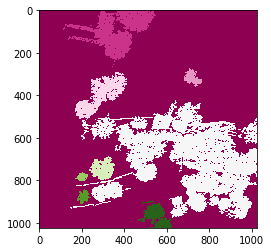

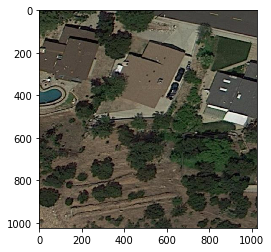

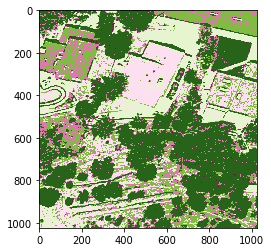

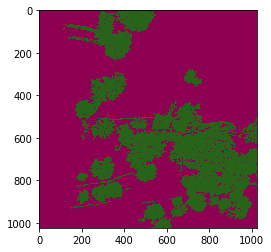

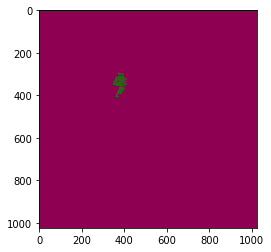

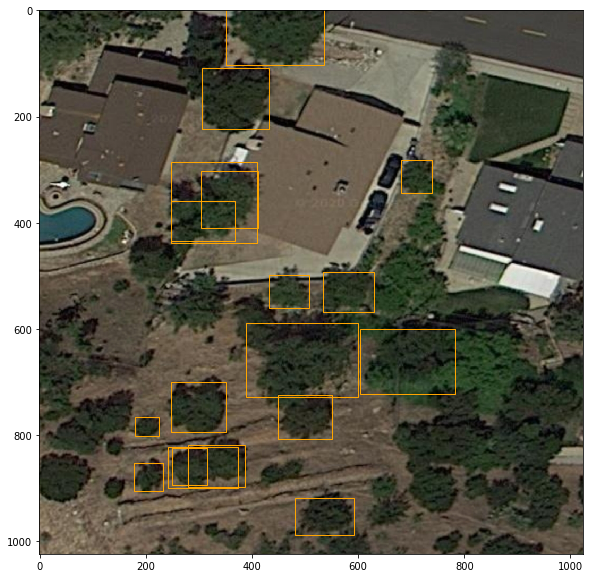

(1024, 1024)
(1024, 1024, 3)


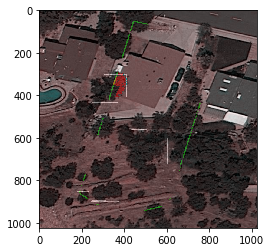

In [26]:
#Generate working example
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import numpy as np

address                                        = '7348 ALPINE WAY LOS ANGELES CA 91042'#'11561 delmont'#'11585 dellmont dr'#'7348 ALPINE WAY LOS ANGELES CA 91042'
address                                        = address_suggestions(master_table, address)[0]
label_image,imfo,center_lat,center_lon,row     = image_by_address(master_table,address, classified = True)
rgb_image,imfo,center_lat,center_lon,row       = image_by_address(master_table,address, classified = False)
class_ids, confidences, boxes1                 = get_tree_bounds(rgb_image)
structure_vertices                             = structures_by_address(master_table,address)
parcel_vertices                                = parcel_boundaries_by_address(master_table,address)
structure_coordinates                          = convert_vertices_to_pixels(structure_vertices, imfo, imsize = 1024)
parcel_coordinates                             = convert_vertices_to_pixels(parcel_vertices, imfo, imsize = 1024)
parcel_pixels                                  = get_parcel_pixels(parcel_coordinates)
parcel_image                                   = get_parcel_image(parcel_pixels)
boxes                                          = trees_on_property(boxes1, parcel_coordinates)
tree_image                                     = map_by_address(label_image, 1000)
tree_image, box_outlines                       = filtered_tree_image(boxes, tree_image)
structure_overlap, structure_flag              = structure_intersection_map(tree_image, structure_coordinates)
structure_overlap,labeled, ncomponents         = remove_small_clusters(structure_overlap, 1500)
parcel_overlap, parcel_flag                    = parcel_intersection_map(tree_image, parcel_image,5, imfo)
overlapping_boxes, unique_boxes_with_overlap   = get_overlapping_boxes(boxes)
print(True in structure_overlap)
all_trees, all_trees_labeled, all_trees_ncomponents = remove_small_clusters(tree_image,0)

plt.imshow(all_trees_labeled,cmap="PiYG")
plt.show()

plt.imshow(rgb_image,cmap="PiYG")
plt.show()

plt.imshow(label_image,cmap="PiYG")
plt.show()

plt.imshow(tree_image,cmap="PiYG")
plt.show()

plt.imshow(structure_overlap,cmap="PiYG")
plt.show()

final_image = generate_flagged_image(rgb_image, structure_overlap, parcel_overlap, structure_flag, parcel_flag)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, aspect='equal')

patches = []
for box in boxes:#unique_boxes_with_overlap:
    patches.append(matplotlib.patches.Rectangle((box[0],box[1]),box[2],box[3], fill=None, color = 'orange'))
ax.add_collection(PatchCollection(patches, match_original = True))
plt.imshow(rgb_image,cmap="PiYG")
plt.show()

print(np.shape(tree_image))
print(np.shape(box_outlines))
final_image = final_image + box_outlines*100
plt.imshow(final_image,cmap="PiYG")
plt.show()

In [87]:
#Generate working example
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd

validation = pd.read_csv('C:/Users/ntste/Documents/Insight/Tree Data/validation.csv')
structure_overlap_predict = []
parcel_overlap_predict    = []
tree_proximity_predict    = []
for address in list(validation['address']):
    print(address)
    #address                                        = '7348 ALPINE WAY LOS ANGELES CA 91042'
    address                                        = address_suggestions(master_table, address)[0]
    print(address)
    label_image,imfo,center_lat,center_lon,row     = image_by_address(master_table,address, classified = True)
    rgb_image,imfo,center_lat,center_lon,row       = image_by_address(master_table,address, classified = False)
    class_ids, confidences, boxes                  = get_tree_bounds(rgb_image)
    structure_vertices                             = structures_by_address(master_table,address)
    parcel_vertices                                = parcel_boundaries_by_address(master_table,address)
    structure_coordinates                          = convert_vertices_to_pixels(structure_vertices, imfo, imsize = 1024)
    parcel_coordinates                             = convert_vertices_to_pixels(parcel_vertices, imfo, imsize = 1024)
    parcel_pixels                                  = get_parcel_pixels(parcel_coordinates)
    parcel_image                                   = get_parcel_image(parcel_pixels)
    boxes                                          = trees_on_property(boxes, parcel_coordinates)
    tree_image                                     = map_by_address(label_image, 1000)
    tree_image, box_outlines                       = filtered_tree_image(boxes, tree_image)
    structure_overlap, structure_flag              = structure_intersection_map(tree_image, structure_coordinates)
    structure_overlap,labeled, ncomponents         = remove_small_clusters(structure_overlap, 1500)
    parcel_overlap, parcel_flag                    = parcel_intersection_map(tree_image, parcel_image,5, imfo)
    overlapping_boxes, unique_boxes_with_overlap   = get_overlapping_boxes(boxes)
    structure_overlap                              = True in structure_overlap
    tree_proximity_flag                            = len(unique_boxes_with_overlap) > 0
    all_trees, all_trees_labeled, all_trees_ncomponents = remove_small_clusters(tree_image,0)
    structure_overlap_predict.append(1*structure_overlap)
    parcel_overlap_predict.append(1*parcel_flag)
    tree_proximity_predict.append(1*tree_proximity_flag)
    

11544 Shelly Vista Dr
11544 SHELLY VISTA DR LOS ANGELES CA 91042
11528 Shelly Vista Dr
11528 SHELLY VISTA DR LOS ANGELES CA 91042
11526 Dellmont Dr
11526 DELLMONT DR LOS ANGELES CA 91042
11592 Dellmont Dr
11592 DELLMONT DR LOS ANGELES CA 91042
11598 Dellmont Dr
11598 DELLMONT DR LOS ANGELES CA 91042
11436 Dellmont Dr
11436 DELLMONT DR LOS ANGELES CA 91042
11442 Dellmont Dr
11442 DELLMONT DR LOS ANGELES CA 91042
11448 Dellmont Dr
11448 DELLMONT DR LOS ANGELES CA 91042
11454 Dellmont Dr
11454 DELLMONT DR LOS ANGELES CA 91042
11460 Dellmont Dr
11460 DELLMONT DR LOS ANGELES CA 91042
11466 Dellmont Dr
11466 DELLMONT DR LOS ANGELES CA 91042
7523 Alpine Way
7523 ALPINE WAY LOS ANGELES CA 91042
7453 Alpine Way
7453 ALPINE WAY LOS ANGELES CA 91042
7439 Alpine Way
7439 ALPINE WAY LOS ANGELES CA 91042
7427 Alpine Way
7427 ALPINE WAY LOS ANGELES CA 91042
7415 Alpine Way
7415 ALPINE WAY LOS ANGELES CA 91042
7304 Alpine Way
7304 ALPINE WAY LOS ANGELES CA 91042
7314 Alpine Way
7314 ALPINE WAY LOS ANG

In [96]:
print(structure_overlap_predict)
print(list(validation['tree overlaps house']))

[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
[0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]


In [98]:
validation = pd.read_csv('C:/Users/ntste/Documents/Insight/Tree Data/validation.csv')
import sklearn.metrics
print(sklearn.metrics.confusion_matrix(list(validation['tree overlaps house']),structure_overlap_predict,labels=[0,1]))
print(sklearn.metrics.confusion_matrix(list(validation['tree overlaps boundary']),parcel_overlap_predict,labels=[0,1]))
print(sklearn.metrics.confusion_matrix(list(validation['trees too close']),tree_proximity_predict,labels=[0,1]))

[[22  1]
 [ 2 13]]
[[ 1  5]
 [ 0 32]]
[[ 7  4]
 [ 8 19]]


In [81]:
print(np.array(list(validation['tree overlaps house'])))

[0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 1]
